<a href="https://colab.research.google.com/github/one-2730/MDP/blob/main/Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 판매량 추정

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


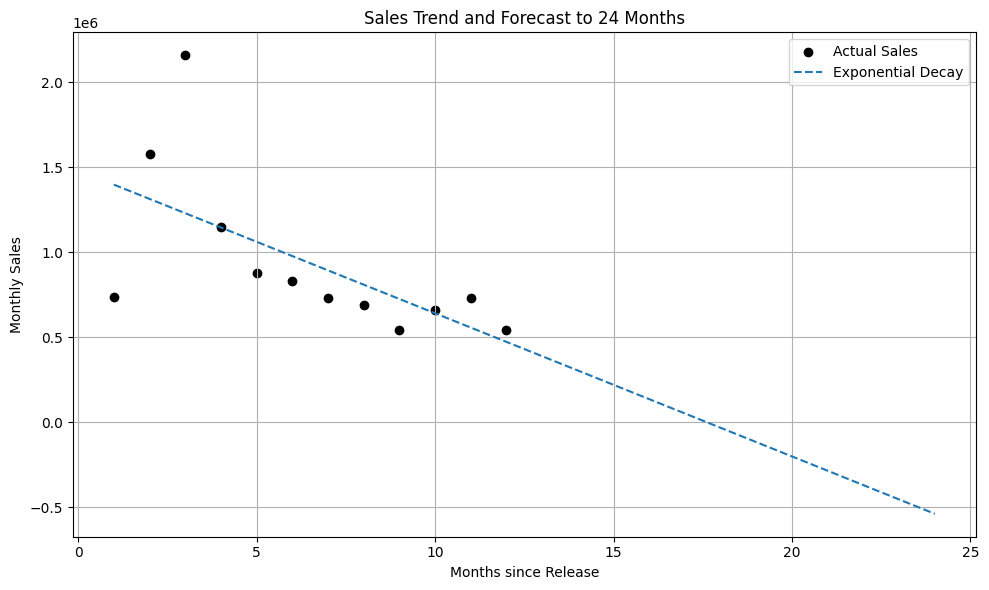

,Month,Exponential Forecast
12,13,388583
13,14,304320
14,15,220042
15,16,135749
16,17,51441
17,18,-32881
18,19,-117219
19,20,-201572
20,21,-285940
21,22,-370324


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 입력 데이터
months = np.arange(1, 13)
sales = np.array([740000, 1579900, 2160100, 1150000, 880000, 830000, 730000, 690000, 540000, 660000, 730000, 540000])

# 데이터 프레임 생성
df = pd.DataFrame({
    'Month': months,
    'Sales': sales
})

# 피팅 함수 정의
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# 커브 피팅
popt_exp, _ = curve_fit(exponential_decay, df['Month'], df['Sales'], maxfev=5000)

# 24개월까지 예측
months_future = np.arange(1, 25)
exp_pred = exponential_decay(months_future, *popt_exp)

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(df['Month'], df['Sales'], color='black', label='Actual Sales')
plt.plot(months_future, exp_pred, label='Exponential Decay', linestyle='--')
plt.xlabel('Months since Release')
plt.ylabel('Monthly Sales')
plt.title('Sales Trend and Forecast to 24 Months')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 출력: 예측값 데이터
forecast_df = pd.DataFrame({
    'Month': months_future,
    'Exponential Forecast': exp_pred.astype(int),
})

plt.show()
forecast_df.tail(12)  # 13~24개월 예측값 보기


#수요 기댓값 추정

In [7]:
import numpy as np
import math

# E[r(t)] 함수
def E_r(t, lam, mu, rho):
    return lam / (mu + rho) * (1 - math.exp(-(mu + rho) * t))

# E[d(m)] 함수
def E_d(z, m, lam, mu, rho):
    n = len(z)
    result = 0
    for i in range(1, m + 1):
        z1_idx = m - i
        z2_idx = m - i - 1
        z1 = z[z1_idx] if 0 <= z1_idx < n else 0
        z2 = z[z2_idx] if 0 <= z2_idx < n else 0
        delta_z = z1 - z2
        result += delta_z * E_r(i, lam, mu, rho)
    return result

# 판매량 벡터
z = [
    740000, 1579900, 2160100, 1150000, 880000, 830000, 730000, 690000,
    540000, 660000, 730000, 540000, 388583, 304320, 220042, 135749, 51441, 0
]

# 파라미터
lam = 0.02   # 고장률
mu = 0.025   # 폐기율
rho = 0.02   # 교체의도 감소율

# 1~48개월 동안의 수요 기대값 계산
E_d_result = []
for m in range(1, 49):
    E_d_result.append(E_d(z, m, lam, mu, rho))

# 출력
for i, val in enumerate(E_d_result, 1):
    print(f"Month {i}: Expected demand = {val:.2f}")

Month 1: Expected demand = 14471.94
Month 2: Expected demand = 44732.73
Month 3: Expected demand = 85008.75
Month 4: Expected demand = 103758.33
Month 5: Expected demand = 116402.57
Month 6: Expected demand = 127512.61
Month 7: Expected demand = 136178.10
Month 8: Expected demand = 143680.03
Month 9: Expected demand = 147918.35
Month 10: Expected demand = 154316.98
Month 11: Expected demand = 161803.01
Month 12: Expected demand = 165243.88
Month 13: Expected demand = 165572.12
Month 14: Expected demand = 164238.02
Month 15: Expected demand = 161314.42
Month 16: Expected demand = 156870.98
Month 17: Expected demand = 150974.28
Month 18: Expected demand = 144331.03
Month 19: Expected demand = 137980.10
Month 20: Expected demand = 131908.63
Month 21: Expected demand = 126104.32
Month 22: Expected demand = 120555.41
Month 23: Expected demand = 115250.67
Month 24: Expected demand = 110179.35
Month 25: Expected demand = 105331.18
Month 26: Expected demand = 100696.34
Month 27: Expected deman

# DQN

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# 환경 클래스 (앞서 작성한 Env 클래스 사용)
class Env:
    def __init__(self, max_inventory=5000000, delta=-9999, time_horizon=48, price=0.3, production_cost=0.03, holding_cost=0.0003, fixed_cost=20, alpha=0.5, mu_list=None):
        self.max_inventory = max_inventory
        self.delta = delta
        self.time_horizon = time_horizon

        self.p = price
        self.q = production_cost
        self.h = holding_cost
        self.f = fixed_cost
        self.alpha = alpha

        self.mu_list = mu_list
        self.sigma_list = mu_list

        self.t = 0
        self.I = 100000
        self.D = self._sample_demand()
        self.L = 1
        self.state = (self.I, int(round(self.D)), self.L)

        self.production_ended = False

    def _sample_demand(self):
        mu = self.mu_list[self.t]
        sigma = self.sigma_list[self.t]
        return max(0, np.random.normal(mu, sigma))  # 수요는 음수 불가

    def get_valid_actions(self):
      if self.L == 0:
        return [self.delta]
      else:
        max_prod = self.max_inventory - self.I
        # 10만 단위 이산화
        max_step = max_prod // 100000
        valid_actions = [i*100000 for i in range(1, max_step+1)]
        valid_actions.append(self.delta)  # 생산 종료 액션
        return valid_actions

    def reset(self):
        self.t = 0
        self.I = 100000
        self.D = self._sample_demand()
        self.L = 1
        self.production_ended = False
        self.state = (self.I, int(round(self.D)), self.L)
        return self.state

    def step(self, action):
      I_t = self.I
      D_t = int(round(self.D))
      a_t = action

      if a_t == self.delta:
        self.production_ended = True

      production_amount = 0 if self.production_ended else a_t

      s_t = min(I_t + production_amount, D_t)
      I_next = I_t + production_amount - s_t

      L_next = 0 if a_t == self.delta else 1

      self.t += 1
      D_next = self._sample_demand() if self.t < self.time_horizon else 0
      reward = (
          self.p * self.alpha * s_t
          - self.q * production_amount
          - self.h * I_next
          - (self.f if not self.production_ended else 0)
      )

      self.I = I_next
      self.D = D_next
      self.L = L_next
      self.state = (self.I, int(round(self.D)), self.L)

      done = self.t >= self.time_horizon
      return self.state, reward, done


# DQN 네트워크
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# 상태 전처리: 정규화 및 tensor 변환 (CPU용)
def preprocess_state(state):
    # 상태: (I, D, L)
    I, D, L = state
    state_array = np.array([I/5_000_000, D/5_000_000, L], dtype=np.float32)
    return torch.tensor(state_array).unsqueeze(0)  # 배치 차원 추가

# DQN 학습 함수
def train_dqn(env, num_episodes=500, gamma=0.95, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, batch_size=64, replay_capacity=20000, learning_rate=1e-4):
    device = torch.device("cpu")

    state_size = 3
    action_list = [i * 100000 for i in range(0, (env.max_inventory // 100000) + 1)]
    action_list.append(env.delta)
    action_size = len(action_list)

    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    memory = deque(maxlen=replay_capacity)

    epsilon = epsilon_start
    rewards_all_episodes = []
    loss_log = []

    for episode in range(num_episodes):
        state = env.reset()
        state_tensor = preprocess_state(state).to(device)

        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            valid_indices = [action_list.index(a) for a in valid_actions]
            # 탐험-활용 정책
            if random.random() < epsilon:
              action_index = random.choice(valid_indices)
              action = action_list[action_index]
            else:
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                    masked_q_values = q_values.clone()
                    for i in range(len(action_list)):
                      if i not in valid_indices:
                        masked_q_values[0, i] =-float('inf')
                    action_index = masked_q_values.argmax().item()
            action = action_list[action_index]

            next_state, reward, done = env.step(action)
            next_state_tensor = preprocess_state(next_state).to(device)

            total_reward += reward

            memory.append((state_tensor, action_index, reward, next_state_tensor, done))
            state_tensor = next_state_tensor

            # 미니배치 학습
            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.cat(states)
                actions = torch.tensor(actions).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                q_values = policy_net(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                    target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

                loss = criterion(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_log.append(loss.item())

        rewards_all_episodes.append(total_reward)

        # 타겟 네트워크 업데이트 주기
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_all_episodes[-50:])
            print(f"Episode {episode+1}, Average Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

    return policy_net, rewards_all_episodes, loss_log

In [17]:
import pandas as pd

df = pd.read_excel('Term Project.xlsx', sheet_name=3)
mu_list = df['E_d'].values

env = Env(mu_list=mu_list)

trained_model, reward_log, loss_log = train_dqn(env, num_episodes=3000)

Episode 50, Average Reward (last 50): 432369.19, Epsilon: 0.778
Episode 100, Average Reward (last 50): 343199.44, Epsilon: 0.606
Episode 150, Average Reward (last 50): 256748.70, Epsilon: 0.471
Episode 200, Average Reward (last 50): 110472.56, Epsilon: 0.367
Episode 250, Average Reward (last 50): 127330.21, Epsilon: 0.286
Episode 300, Average Reward (last 50): 58430.88, Epsilon: 0.222
Episode 350, Average Reward (last 50): 112606.40, Epsilon: 0.173
Episode 400, Average Reward (last 50): 83660.98, Epsilon: 0.135
Episode 450, Average Reward (last 50): 45474.01, Epsilon: 0.105
Episode 500, Average Reward (last 50): 52608.36, Epsilon: 0.082
Episode 550, Average Reward (last 50): 44900.78, Epsilon: 0.063
Episode 600, Average Reward (last 50): 14954.98, Epsilon: 0.049
Episode 650, Average Reward (last 50): 32735.28, Epsilon: 0.038
Episode 700, Average Reward (last 50): 36091.52, Epsilon: 0.030
Episode 750, Average Reward (last 50): 14956.99, Epsilon: 0.023
Episode 800, Average Reward (last 5

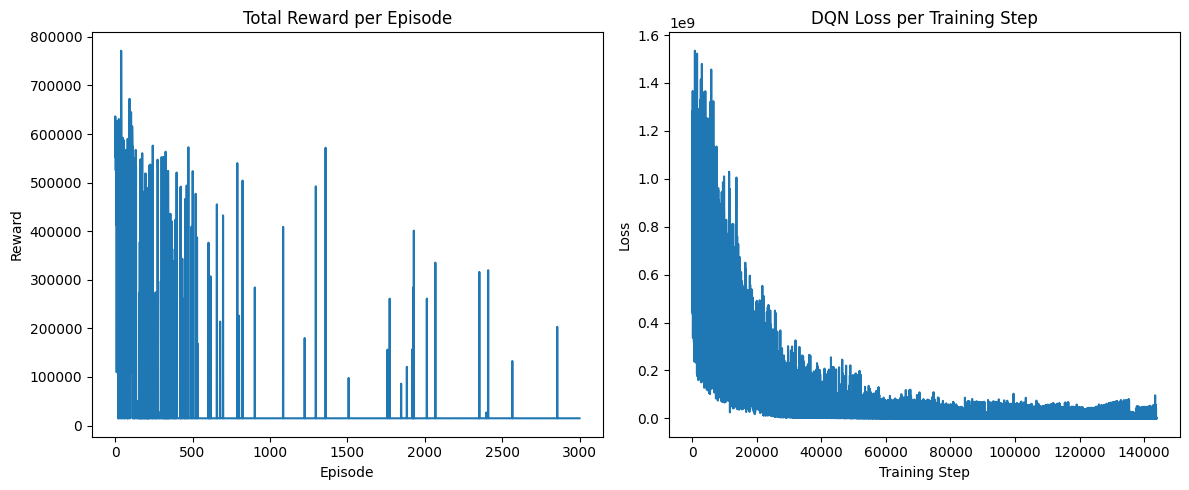

In [18]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(reward_log)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(loss_log)
plt.title("DQN Loss per Training Step")
plt.xlabel("Training Step")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [21]:
def test_trained_policy(env, model, preprocess_state, max_steps=50):
    device = torch.device("cpu")
    state = env.reset()
    total_reward = 0
    done = False

    # 학습 시와 동일한 action_list 사용
    action_list = [i * 100000 for i in range(0, (env.max_inventory // 100000) + 1)]
    action_list.append(env.delta)

    model.eval()

    for step in range(max_steps):
        state_tensor = preprocess_state(state).to(device)
        valid_actions = env.get_valid_actions()
        valid_indices = [action_list.index(a) for a in valid_actions]

        with torch.no_grad():
            q_values = model(state_tensor)
            masked_q_values = q_values.clone()
            for i in range(len(action_list)):
                if i not in valid_indices:
                    masked_q_values[0, i] = -float('inf')  # invalid action masking
            action_index = masked_q_values.argmax().item()
            action = action_list[action_index]

        next_state, reward, done = env.step(action)
        print(f"Step {step}: State={state}, Action={action}, Reward={reward:.2f}")
        total_reward += reward
        state = next_state
        if done:
            break

    print(f"\nTotal reward in test episode: {total_reward:.2f}")
    return total_reward

In [22]:
total_reward = test_trained_policy(env, trained_model, preprocess_state=preprocess_state)

Step 0: State=(100000, 25849, 1), Action=-9999, Reward=3855.10
Step 1: State=(74151, 83033, 0), Action=-9999, Reward=11122.65
Step 2: State=(0, 256057, 0), Action=-9999, Reward=0.00
Step 3: State=(0, 68466, 0), Action=-9999, Reward=0.00
Step 4: State=(0, 85509, 0), Action=-9999, Reward=0.00
Step 5: State=(0, 14806, 0), Action=-9999, Reward=0.00
Step 6: State=(0, 138064, 0), Action=-9999, Reward=0.00
Step 7: State=(0, 150893, 0), Action=-9999, Reward=0.00
Step 8: State=(0, 301366, 0), Action=-9999, Reward=0.00
Step 9: State=(0, 29884, 0), Action=-9999, Reward=0.00
Step 10: State=(0, 283353, 0), Action=-9999, Reward=0.00
Step 11: State=(0, 284163, 0), Action=-9999, Reward=0.00
Step 12: State=(0, 3385, 0), Action=-9999, Reward=0.00
Step 13: State=(0, 46517, 0), Action=-9999, Reward=0.00
Step 14: State=(0, 65493, 0), Action=-9999, Reward=0.00
Step 15: State=(0, 150025, 0), Action=-9999, Reward=0.00
Step 16: State=(0, 0, 0), Action=-9999, Reward=0.00
Step 17: State=(0, 0, 0), Action=-9999, 